In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space, extract_segments_aligned
from scipy.signal import find_peaks


plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# 1. Paths and Read-In (segmentation mask based)

In [2]:
# For the automation consider only the segemnted examples
masks_dir = "../data/videos/leeching/philodina/seg_masks/"
masks_path_names = sorted([dir for dir in os.listdir(masks_dir) if dir.endswith("masks")])
mask_filepaths = [f"{masks_dir}{mpath}/"for mpath in masks_path_names]

# Corresponding videos
vid_path = "../data/videos/leeching/philodina/ori_videos/"
vid_filenames = [fn.split("_masks")[0] + ".MP4" for fn in masks_path_names]
vid_props = {k : get_video_properties(vid_path, k) for k in vid_filenames}
df = pd.DataFrame.from_dict(vid_props, orient="index").reset_index()
df.columns = ["filename", "fps", "num_frames", "width", "height"]

# Scale
pixel_per_real_width =  2.127659 #  >> for Dlow
mpp = 0.47 # microns_per_pixel for Dlow
print("D low - FHD, pixel_per_real_width = ", pixel_per_real_width)
    
df

D low - FHD, pixel_per_real_width =  2.127659


,filename,fps,num_frames,width,height
0,2024_0430_200515_048.MP4,60,2354,1920,1080
1,2024_0502_183848_065.MP4,60,1038,1920,1080
2,2024_0502_184114_068.MP4,60,843,1920,1080
3,2024_0502_184450_071.MP4,60,2074,1920,1080
4,2024_0502_184534_072.MP4,60,2156,1920,1080
5,2024_0502_184616_073.MP4,60,1372,1920,1080
6,2024_0502_184929_077.MP4,60,776,1920,1080
7,2024_0502_184947_078.MP4,60,756,1920,1080
8,2024_0502_185400_083.MP4,60,1333,1920,1080
9,2024_0502_185557_084.MP4,60,1648,1920,1080


# 2. Select a recording

In [3]:
# Get Segmentation masks > results of tracking
cidx = 4  # 4, min_area=2200
vid_filename = df.loc[cidx, "filename"]; print(vid_filename)

fps = df.loc[cidx, "fps"]
num_frames = df.loc[cidx, "num_frames"]
cmask_filepath = mask_filepaths[cidx]

# Masks
cmask_filenames = sorted([f for f in os.listdir(cmask_filepath) if f.endswith("png")])
cmask_filepaths = [os.path.join(cmask_filepath, fn) for fn in cmask_filenames]

# Set num_frames to the desired value > trows an unexpected error in the rotation function...
#num_frames = 1600
#cmask_filepaths = cmask_filepaths[:num_frames]

# Get contours from masks
frames = np.arange(0, len(cmask_filepaths))
time = np.linspace(0, num_frames / fps, num_frames)
frames_max = 1600
t_max = time[frames_max]

# Get contour stats
contour_list = get_contours_from_segmasks(cmask_filepaths)
df_stats = get_contour_stats(contour_list, min_area=2200)
print(df_stats["area"].min())

# Save figures
results_path = "../data/results/leeching/"
save_figure_path = os.path.join(results_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)

# export selected frames only
EXPORT_FRAMES = False
export_frames = np.arange(0, frames_max)  # export frames, rather!
img_save_dir = f"../data/images/{vid_filename.split('.MP4')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

2024_0502_184534_072.MP4
2261.0


# 2. Rotate Masks and Contours

In [4]:
# Rotatation parameters
cm_x, cm_y = df_stats[["centroid_x", "centroid_y"]].values.T
centers = [(x, y) for x, y in zip(cm_x, cm_y)]
rot_angles = df_stats["orientation"].values  # fitted ellipse angle
print(np.isnan(centers).sum())

# rotate masks and get rotated contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, cmask_filepaths)
# find top and bottom most points
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
df_points = transform_points_to_original_space(df_top_bot, centers, rot_angles * -1)

2


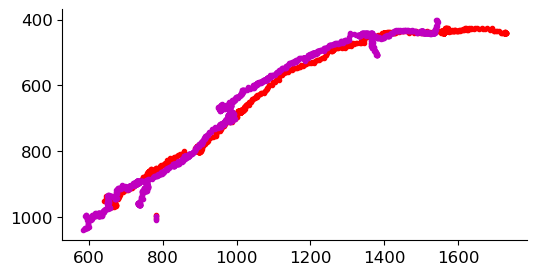

In [5]:
plt.plot(df_points["top_x"], df_points["top_y"], ".r")
plt.plot(df_points["bottom_x"], df_points["bottom_y"], ".m")
plt.gca().invert_yaxis()

In [6]:
wsize=20
smooth_centroid_dist = df_stats["centroid_dist"].rolling(window=wsize).mean()
back = np.sqrt(df_points["top_x"].diff().rolling(window=wsize).mean() ** 2 + df_points["top_y"].diff().rolling(window=wsize).mean() ** 2)
front = np.sqrt(df_points["bottom_x"].diff().rolling(window=wsize).mean() ** 2 + df_points["bottom_y"].diff().rolling(window=wsize).mean() ** 2)

In [7]:
save_figure_path

'../data/results/leeching/2024_0502_184534_072'

# Plotting

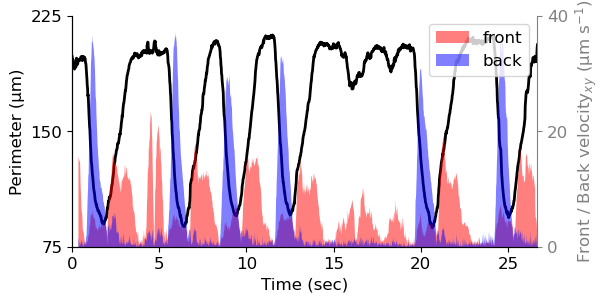

In [8]:
# With back and front
SAVE_FIGURE = False
ax_params = dict(xlim=(0, t_max), ylim=(75, 225), xlabel='Time (sec)', ylabel='Perimeter (µm)', yticks=[75, 150, 225])
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time, df_stats["perimeter"] * mpp, "-k", lw=2)
ax.set(**ax_params)
ax.tick_params(axis='both', which='major')#, labelsize=12)

# MIND THAT THERE IS STUFF BEYOND XLIM!!!!
ax2_params = dict(ylim=(0, 40), yticks=[0,20,40], ylabel="Front / Back velocity$_x$$_y$ (µm s$^{-1}$)")

ax2 = plt.twinx()
ax2.fill_between(time[:frames_max], front[:frames_max] * (1000/fps) * mpp, color="red", alpha=.5, linewidth=0, label="front")
ax2.fill_between(time[:frames_max], back[:frames_max] * (1000/fps) * mpp, color="blue", alpha=.5, linewidth=0, label="back")
ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color("gray")
ax2.yaxis.label.set_color("gray")
ax2.set(**ax2_params)
ax2.tick_params(axis="y", color="gray")
ax2.legend(frameon=True, loc="best")
ax2.set_yticklabels(labels=[0,20,40], color="gray")

fig.savefig(f"{save_figure_path}/perimeter_and_BF-centroids_mpp_time-course_.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

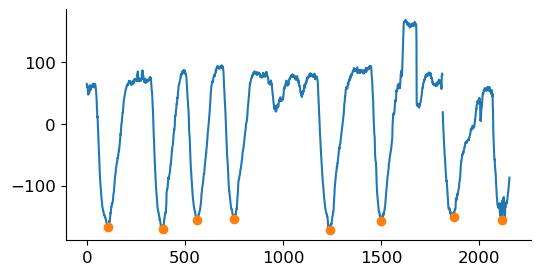

In [9]:
signal = df_stats["perimeter"].to_numpy()
signal = signal - np.nanmean(signal)
troughs, _ = find_peaks(-signal, distance=120, height=0)  # Adjust distance as needed

plt.plot(frames, signal)
plt.plot(frames[troughs], signal[troughs], "o", label="troughs")

In [10]:
before, after = 90, 90
t_aligned = np.arange(-before, after) /fps
tperimeter = df_stats["perimeter"].to_numpy() * mpp

aligned_segments = extract_segments_aligned(tperimeter, troughs[:-1], before=before, after=after)
aligned_front = extract_segments_aligned(front * (1000/fps) * mpp, troughs[:-1])
aligned_back = extract_segments_aligned(back * (1000/fps) * mpp, troughs[:-1])

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_44363/1546387339.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  ax[1].plot(t_aligned, aligned_back.T, "-b", color="lightblue", lw=1);


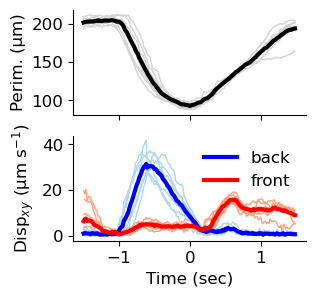

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(3, 3))
ax[0].plot(t_aligned, aligned_segments.T, "-", lw=1, color="lightgray");
ax[0].plot(t_aligned, np.nanmean(aligned_segments, axis=0), "-k", lw=3);
ax[0].set(xticklabels=[], ylabel="Perim. (µm)")

ax[1].plot(t_aligned, aligned_front.T, "-", color="lightsalmon", lw=1);
ax[1].plot(t_aligned, aligned_back.T, "-b", color="lightblue", lw=1);

ax[1].plot(t_aligned, np.nanmean(aligned_back, axis=0), "-b", lw=3, label="back"); #"cm$_b$"
ax[1].plot(t_aligned, np.nanmean(aligned_front, axis=0), "-r", lw=3, label="front"); # cm$_f$"
ax[1].set(xlabel="Time (sec)", ylabel="Disp$_x$$_y$ (µm s$^{-1}$)")
ax[1].legend(frameon=False)
fig.savefig(f"{save_figure_path}/perimeter_and_BF-trough-triggered.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

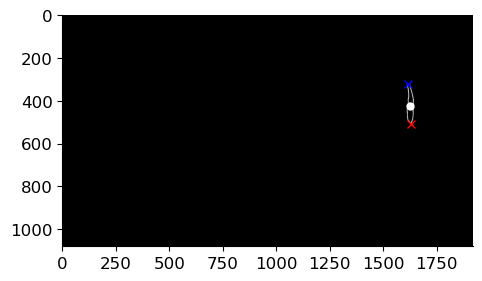

In [15]:
idx = 2
cmask = cv2.cvtColor(cv2.imread(cmask_filepaths[idx], 1), cv2.COLOR_BGR2GRAY)
background = np.zeros_like(cmask)

cv2.drawContours(background, [rot_contours[idx]], 0, (255,0,0), thickness=2)
plt.imshow(background, cmap="gray")
plt.plot(cm_x[idx], cm_y[idx], "ow", ms=5)

plt.plot(df_top_bot.loc[idx, "top_x"], df_top_bot.loc[idx, "top_y"], "xb", ms=6)
plt.plot(df_top_bot.loc[idx, "bottom_x"], df_top_bot.loc[idx, "bottom_y"], "xr", ms=6)

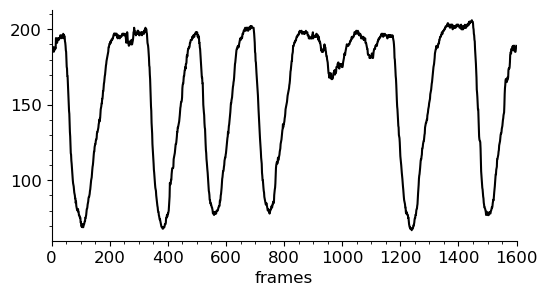

In [108]:
df_top_bot = df_top_bot[:frames_max]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(frames[:frames_max], df_top_bot["distance"], "-k")
ax.set_xlim(0, frames_max)
ax.set_xlabel("frames")
ax.minorticks_on()
fig.savefig(f"{save_figure_path}/length_frames-course.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

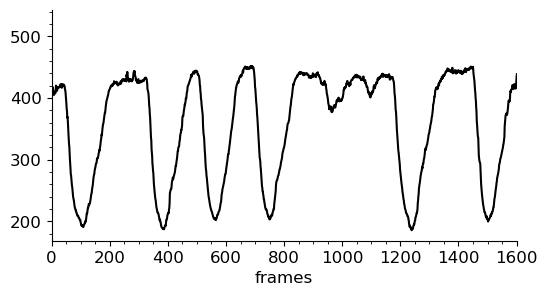

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(frames, df_stats["perimeter"], "-k")
ax.set_xlim(0, frames_max)
ax.set_xlabel("frames")
ax.minorticks_on()
fig.savefig(f"{save_figure_path}/perimeter_frames-course.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

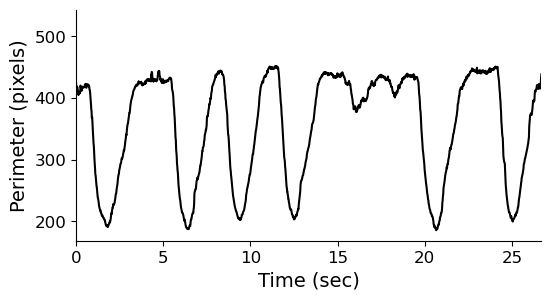

In [11]:
# TAKE CARE OF FONTSIZES!!!!
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time, df_stats["perimeter"], "-k")
ax.set_xlim(0, t_max)
ax.set_xlabel('Time (sec)', fontsize=14)
ax.set_ylabel('Perimeter (pixels)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.savefig(f"{save_figure_path}/perimeter_time-course.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

# Aligned movement

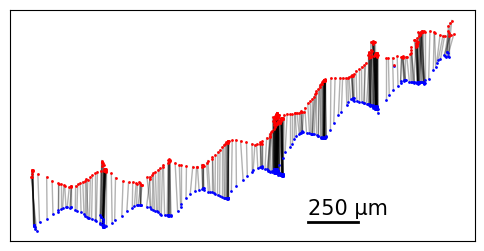

In [12]:
SAVE_FIGURE = False

every_nth = 6
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(0, len(df_top_bot), every_nth):
    ax.plot([df_top_bot["top_x"].iloc[i], df_top_bot["bottom_x"].iloc[i]],
             [df_top_bot["top_y"].iloc[i], df_top_bot["bottom_y"].iloc[i]], 'k-', lw=1, alpha=.3)

ax.plot(df_top_bot["top_x"][::every_nth], df_top_bot["top_y"][::every_nth], "ob", ms=2, alpha=1, label="back", mec="None")
ax.plot(df_top_bot["bottom_x"][::every_nth], df_top_bot["bottom_y"][::every_nth], "or", ms=2, alpha=1, label="front", mec="None")
ax.invert_xaxis()
for spine in ax.spines.values():
    spine.set_visible(True)
#ax.legend()
#

SCALEBAR = True
if SCALEBAR:
    ax.set(xticks=[], yticks=[])
    desired_scale_width = 250  # in mu
    scaled_width = desired_scale_width / (pixel_per_real_width)
    scalebar_posxy = [850, 350]

    ax.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
    ax.text(scalebar_posxy[0] + (scaled_width), scalebar_posxy[-1] + 25, f"{desired_scale_width} µm", fontsize=15)

fig.savefig(f"{save_figure_path}/back-front-time-course_every{every_nth}_frame.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


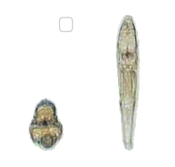

In [13]:

# add example image back-front marked into this plot
#frame_index 100 und 200!
example_frames = [100, 200]
zfill_ = 5
example_mask_paths = [cmask_filepaths[fr] for fr in example_frames]
example_image_paths = [os.path.join(img_save_dir, f"frame_{str(fr).zfill(zfill_)}.jpg") for fr in example_frames]
example_centers = [centers[fr] for fr in example_frames]
example_rot_angles = [rot_angles[fr] for fr in example_frames]

_, example_rot_contours = rotate_masks_and_contours(example_centers, example_rot_angles, example_mask_paths)
example_rot_masks, example_rot_images = rotate_masks_and_images(example_centers, example_rot_angles, example_mask_paths, example_image_paths)
df_top_bot_example = pd.DataFrame(find_top_bottom_points_from_contours(example_rot_contours))

background = np.ones_like(example_rot_images[0]) * 255
#background = np.zeros_like(example_rot_images[0])
masked_images = []

for mask, img in zip(example_rot_masks, example_rot_images):
    #img = cv2.cvtColor(cv2.imread(sel_img, 1), cv2.COLOR_BGR2RGB)
    #mask = cv2.cvtColor(cv2.imread(sel_mask, 1), cv2.COLOR_BGR2GRAY)
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    masked_image = np.uint8((masked_image / np.max(masked_image)) * 253)
    masked_image = np.where(masked_image != 0, masked_image, background)
    masked_images.append(masked_image)

fig, ax = plt.subplots(1, 2, figsize=(2, 2))
ax[0].imshow(masked_images[0])
ax[0].set(xlim=(df_top_bot_example.top_x[0]-50, df_top_bot_example.top_x[0]+50), ylim=(df_top_bot_example.top_y[0]-10,df_top_bot_example.top_y[0]+200))
ax[0].axis("off")
ax[0].legend()

ax[1].imshow(masked_images[-1])
ax[1].set(xlim=(df_top_bot_example.top_x[1]-50, df_top_bot_example.top_x[1]+50), ylim=(df_top_bot_example.top_y[1]-10,df_top_bot_example.top_y[1]+200))
ax[1].axis("off")


fig.savefig(f"{save_figure_path}/back-front-example_frames.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

# plot the back + front points
# relook code to make it simpler!!!

In [14]:
# rotate selected images, masks etc
selected_frames = [25, 395, 650, 1225, 1565]

zfill_ = 5
selected_mask_paths = [cmask_filepaths[fr] for fr in selected_frames]
selected_image_paths = [os.path.join(img_save_dir, f"frame_{str(fr).zfill(zfill_)}.jpg") for fr in selected_frames]
selected_centers = [centers[fr] for fr in selected_frames]
selected_rot_angles = [rot_angles[fr] for fr in selected_frames]

rot_masks_sel, rot_contours_sel = rotate_masks_and_contours(selected_centers, selected_rot_angles, selected_mask_paths)
_, rot_images_sel = rotate_masks_and_images(selected_centers, selected_rot_angles, selected_mask_paths, selected_image_paths)

df_top_bot_sel = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours_sel))
df_stats_sel = df_stats.iloc[selected_frames]

In [15]:
background = np.zeros_like(rot_images_sel[0])
masked_images = []

for sel_mask, sel_img in zip(selected_mask_paths, selected_image_paths):
    img = cv2.cvtColor(cv2.imread(sel_img, 1), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(sel_mask, 1), cv2.COLOR_BGR2GRAY)
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    masked_images.append(masked_image)

# Merge frames
merged_frame = np.zeros_like(rot_images_sel[0])
for frame in masked_images:
    merged_frame = cv2.add(merged_frame, frame)

# rescale merged frame
merged_frame = np.uint8((merged_frame / np.max(merged_frame)) * 253)

# Add white as background
background = np.ones_like(rot_images_sel[0]) * 255
merged_frame = np.where(merged_frame != 0, merged_frame, background)
print(np.max(merged_frame), np.min(merged_frame))

255 1


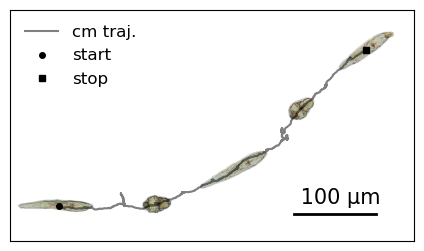

In [26]:
SAVE_FIGURE = False
ts = selected_frames[0]
te = selected_frames[-1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.imshow(merged_frame)
ax.plot(cm_x[ts:te], cm_y[ts:te], "-", color="k", alpha=.5, label="cm traj.")
ax.plot(cm_x[ts], cm_y[ts], "o", color="k", ms=4, mec=None, label="start")
ax.plot(cm_x[te], cm_y[te], "s", color="k", ms=4, mec=None, label="stop")
ax.set(xlim=(700, 1750), ylim=(350, 950))
ax.invert_xaxis()
ax.legend(frameon=False)

for spine in ax.spines.values():
    spine.set_visible(True)


SCALEBAR = True
if SCALEBAR:
    ax.set(xticks=[], yticks=[])
    desired_scale_width = 100  # in mu
    scaled_width = desired_scale_width / mpp
    scalebar_posxy = [800, 420]

    ax.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
    ax.text(scalebar_posxy[0] + (scaled_width), scalebar_posxy[-1] + 25, f" {desired_scale_width} µm", fontsize=15)
    
fig.savefig(f"{save_figure_path}/trajectory-example.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None


In [ ]:
centered_contours_sel = normalize_contours_by_centers(rot_contours_sel, selected_centers)
shifted_contours = shift_contours(centered_contours_sel, 1000, 500)

In [ ]:
# for contour in centered_contours_sel:
#     plt.plot(contour[:,:,0], contour[:,:,1], color='blue')
# plt.axis("equal")

In [27]:
desired_cmap = "twilight_shifted" # "coolwarm"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(shifted_contours))]

background = np.ones_like(rot_images_sel[0]) * 255

for nth, contour in enumerate(shifted_contours):
    ccolors = colors[nth]
    ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
    cv2.drawContours(background, [contour], 0, (ccolors[0], ccolors[1], ccolors[2]), 1)

#plt.imshow(background, cmap="coolwarm")
plt.figure(figsize=(5,6), layout="constrained")
plt.imshow(background)
plt.xlim(950,1050), plt.ylim(350,600)
#plt.axis("equal")

NameError: name 'shifted_contours' is not defined

In [ ]:
background = np.zeros_like(rot_masks_sel[0])

cv2.drawContours(background, rot_contours_sel, -1, (255,0,0), thickness=2)
plt.imshow(background, cmap="gray")
#plt.plot(cm_x[idx], cm_y[idx], "ow", ms=10)

In [ ]:
# SAVE_VIDEO = True

# vid_size = (rot_imgs[0].shape[1], rot_imgs[0].shape[0])
# print(vid_size)
# if SAVE_VIDEO:
#     video = cv2.VideoWriter(f"{vid_path}{vid_filename}_rotated_video_center_color_.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=fps, frameSize=vid_size, isColor=True)
#     counter = 0

#     for frame in rot_imgs:
#         #frame = cv2.cvtColor(frame)
#         frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#         cv2.putText(frame, f"frame{str(counter).zfill(zfill_)}", (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
#         video.write(frame)
#         counter += 1

#     cv2.destroyAllWindows()
#     video.release()

In [ ]:
# cutout_width = 50  # Specify width of the cutout region
# cutout_height = 50  # Specify height of the cutout region

# cutout = perform_cutout(rotated_image, center_x, center_y, cutout_width, cutout_height)


# def perform_cutout(image, center_x, center_y, cutout_width, cutout_height):
#     # Calculate the coordinates of the cutout region
#     top_left_x = int(center_x - cutout_width / 2)
#     top_left_y = int(center_y - cutout_height / 2)
#     bottom_right_x = int(center_x + cutout_width / 2)
#     bottom_right_y = int(center_y + cutout_height / 2)

#     # Ensure the cutout region is within the image boundaries
#     top_left_x = max(top_left_x, 0)
#     top_left_y = max(top_left_y, 0)
#     bottom_right_x = min(bottom_right_x, image.shape[1])
#     bottom_right_y = min(bottom_right_y, image.shape[0])

#     # Perform the cutout
#     cutout = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

#     return cutout